# AI Agents: Architectures (Part-6)

# Table of Contents
1. Introduction
2. Agent Architectures
- 2.1 Reactive Architectures
- 2.2 Deliberative Architecture
- 2.3 Hybrid Architecture
- 2.4 Neural-Symbolic Architecture
- 2.5 Cognitive Architecture
3. Agentic Design Patterns In LangGraph
- 3.1 Multi-Agent Systems
- 3.2 Planning Agents
- 3.3 Reflection & Critique
4. Multi-agent systems
- 4.1 Multi-agent Network
- 4.2 Multi-agent Supervisor
- 4.3 Hierarchical Agent Teams
5. Planning Agents
- 5.1 Plan-and-execute
- 5.2 Reasoning without observation
- 5.3 LLMCompiler
6. Reflection & Critique
- 6.1 Basic Reflection
- 6.2 Reflexion
- 6.3 Tree of Thoughts
- 6.4 Language Agent Tree Search
- 6.5 Self-Discover Agent
7. Conclusion

# 1. Introduction

- Việc lựa chọn kiến trúc phù hợp là quan trọng để xây dựng các tác nhân AI hiệu quả
- Kiến trúc quyết định khả năng của tác nhân về tốc độ phản hồi, xử lý độ phức tạp, khả năng thích ứng học tập và yêu cầu tài nguyên

# 2. Agent Architectures

Kiến trúc tác nhân được phân loại rộng rãi thành:
- Reactive (phản ứng)
- Deliberative (cân nhắc)
- Hybrid (hỗn hợp)
- Neural-Symbolic (thần kinh-biểu tượng)
- Cognitive (nhận thức)

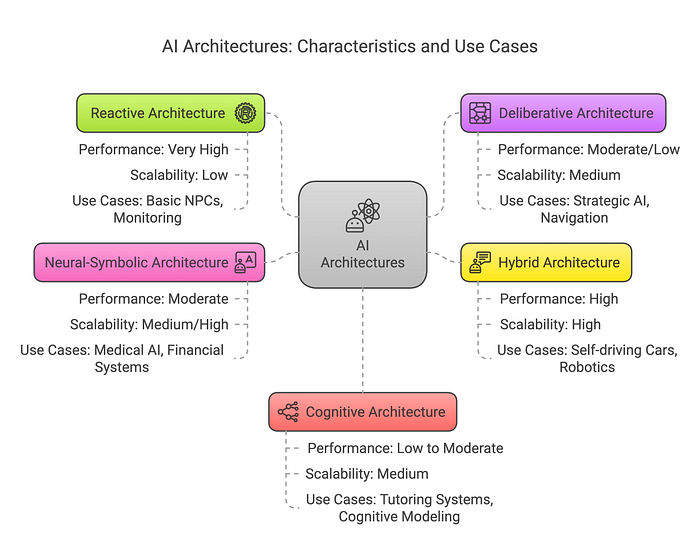

## 2.1 Reactive Architectures
### 2.1.1 Use Cases
- Kiến trúc phản ứng rất phù hợp với các lĩnh vực đòi hỏi quyết định tức thời và có phản ứng dự đoán được, rõ ràng
- Trong môi trường công nghiệp, các tác nhân giám sát đơn giản có thể kích hoạt báo động hoặc tắt máy khi cảm biến vượt ra khỏi phạm vi. Các tác nhân này tỏ ra hiệu quả trong các hệ thống điều khiển thời gian thực, nhưng vì thiếu khả năng lập kế hoạch tổng thể, chúng chỉ được sử dụng cho các tác vụ tương đối đơn giản hoặc bị ràng buộc chặt chẽ, trong đó các quy tắc cho mọi tình huống có thể được xác định trước.

Các mẫu thiết kế React có thể được xây dựng dễ dàng chỉ bằng mã nguồn thuần túy mà không cần sử dụng framework cho các tác vụ đơn giản. Đầu tiên, chúng ta cần một mô hình ngôn ngữ lớn để hoạt động như bộ não của tác nhân:

In [ ]:
from dotenv import load_dotenv
from openai import OpenAI

_ = load_dotenv()
client = OpenAI()

Sau đó, chúng ta có thể xây dựng tác nhân đơn giản của mình như một lớp để trả về các thông báo:

In [ ]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o", 
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content

Sau đó, chúng ta cần một lời nhắc hệ thống để đưa ra hướng dẫn cho tác nhân của mình hoàn thành nhiệm vụ bằng hai công cụ khác

In [ ]:
import openai
import re
import httpx
import os

prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions."""

Bây giờ chúng ta có thể xây dựng tác nhân của mình bằng cách chạy nó qua một vòng lặp để hoạt động theo nhiều bước:

In [ ]:
abot = Agent(prompt)

def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

# Thought: I need to find the average weight of a Border Collie and a Scottish Terrier, then add them together to get the combined weight.
# Action: average_dog_weight: Border Collie
# PAUSE
#  -- running average_dog_weight Border Collie
# Observation: a Border Collies average weight is 37 lbs
# Action: average_dog_weight: Scottish Terrier
# PAUSE
#  -- running average_dog_weight Scottish Terrier
# Observation: Scottish Terriers average 20 lbs
# Thought: Now that I have the average weights of both dogs, I can calculate their combined weight by adding them together.
# Action: calculate: 37 + 20
# PAUSE
#  -- running calculate 37 + 20
# Observation: 57
# Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbst

### 2.1.2 Strengths & Limitations
- Điểm mạnh chính của kiến trúc phản ứng là tốc độ. Không cần suy luận phức tạp, các quyết định được đưa ra trong thời gian thực, lý tưởng cho các lĩnh vực như robot thời gian thực hoặc giao dịch tần suất cao, nơi mà từng mili giây đều quan trọng.
- Các tác nhân phản ứng cũng tương đối dễ thiết kế và xác minh vì hành vi của chúng được xác định rõ ràng bằng các quy tắc.
- Mặt hạn chế là khả năng thích ứng của họ bị hạn chế vì họ không học hỏi hoặc lập kế hoạch, họ không thể dễ dàng xử lý các tình huống không lường trước hoặc giải quyết các vấn đề đòi hỏi trình tự hành động hướng tới mục tiêu.
- Chúng cũng có xu hướng thiển cận, tối ưu hóa các phản ứng tức thời nhưng không xem xét đến hậu quả lâu dài (một robot phản ứng có thể lang thang vô tận trong một vòng lặp nhỏ nếu các quy tắc của nó không kết hợp một số logic chiến lược). Những hạn chế này đã thúc đẩy sự phát triển của các kiến trúc tiên tiến hơn kết hợp trạng thái nội bộ và lý luận.

## 2.2 Deliberative Architecture
- Tác nhân cân nhắc là tác nhân dựa trên mô hình, hướng đến mục tiêu, suy luận trước khi hành động.
- Không giống như tác nhân phản ứng tức thời, tác nhân cân nhắc suy nghĩ trước, đánh giá nhiều hành động khả thi bằng mô hình nội bộ và chọn phương án tốt nhất để đạt được mục tiêu.

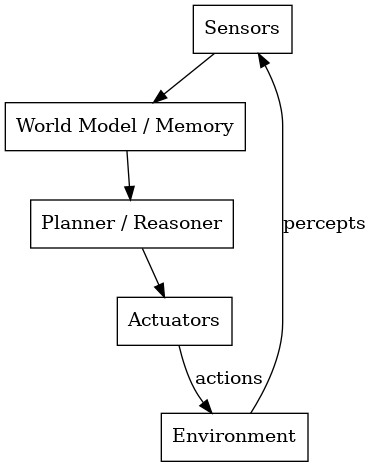

**Sense → Model → Plan → Act**
1. Nhận thức: Tiếp nhận thông tin mới từ môi trường.
2. Model: Update the internal world model (e.g. symbolic state, semantic map).
3. Deliberate: Generate possible plans and simulate/evaluate their outcomes.
4. Act: Execute the best plan or next step toward the goal.

Cách tiếp cận này giống như cách một AI chơi cờ vua lên kế hoạch trước nhiều nước đi thay vì phản ứng từng nước đi.

Ví dụ: Một vòng lặp tác nhân cân nhắc được đơn giản hóa (lấy cảm hứng từ các nguyên tắc BDI) có thể trông như sau:

```python
# Pseudocode for a deliberative agent with goal-oriented planning
initialize_state()
while True:
    perceive_environment(state)
    options = generate_options(state)            # possible plans or actions
    best_option = evaluate_options(options)      # deliberation: select best plan
    commit_to_plan(best_option, state)           # update intentions
    execute_next_action(best_option)
    if goal_achieved(state):
        break
```
- Trong vòng lặp này, generate_options có thể tạo ra các hành động hoặc kế hoạch khả thi dựa trên trạng thái và mục tiêu hiện tại, evaluate_options áp dụng lý luận hoặc lập kế hoạch, tác nhân thực hiện các hành động từng bước, đánh giá lại sau mỗi bước nếu cần
- Điều này phản ánh cách một tác nhân cân nhắc xem xét các hậu quả trong tương lai và tối ưu hóa cho các mục tiêu dài hạn. 

## 2.3 Hybrid Architecture
- Hybrid là sự kết hợp của reactive và deliberative để đạt được hai mục đích là: thông minh và tốc độ trong môi trường
- Reactive Layer: Phản ứng tức thời với các tín hiệu cảm biến
- Deliberative Layer: Lập kế hoạch theo mục tiêu bằng cách sử dụng mô hình nội bộ
- Các lớp này hoạt động cùng nhau, thường song song để cân bằng giữa phản ứng nhanh và chiến lược dài hạn

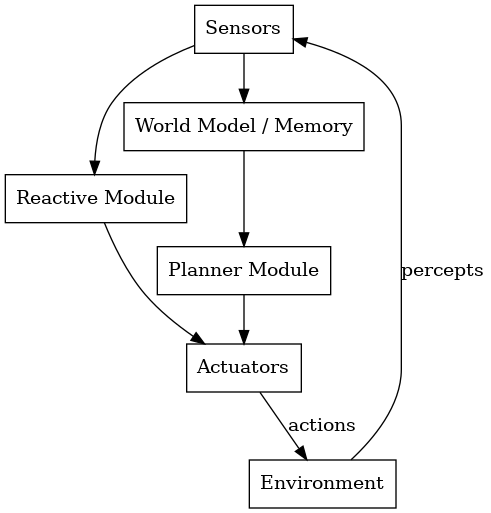

Kiếu trúc thường được cấu trúc theo từng lớp:
- Bottom: cấp thấp và phản ứng theo "bản năng"
- Middle (optional): Sắp xếp/phối hợp
- Top: Cân nhắc, lý luận mục tiêu và lập kế hoạch
- A coordination mechanism (như là giám sát viên hoặc bộ quy tắc): xác định đầu ra của lớp nào được ưu tiên

```python
percept = sense_environment()

if is_urgent(percept):                      
    action = reactive_module(percept)       # Quick reflex
else:
    update(world_model, percept)
    action = deliberative_planner(world_model, current_goal)

execute(action)
```
Logic này đảm bảo tính an toàn và hiệu quả, thích ứng với cả các mối đe dọa trước mắt và các mục tiêu dài hạn.

## 2.4 Neural-Symbolic Architecture
Kiến trúc thần kinh biểu tượng kết hợp từ mạng nơ-ron để học từ dữ liệu với AI biểu tượng để suy luận dựa trên quy tắc, cho phép tác nhân vừa nhận thức được môi trường phức tạp vừa suy luận về chúng

- Neural Networks: tốt trong nhận dạng mẫu (image, speech...)
- Symbolic Systems: Giỏi về logic, lý luận và khả năng giải thích
- Combined Goal: Tận dụng nhận thức thần kinh và hiểu biết biểu tượng để đưa ra quyết định thông minh có thể giải thích được.

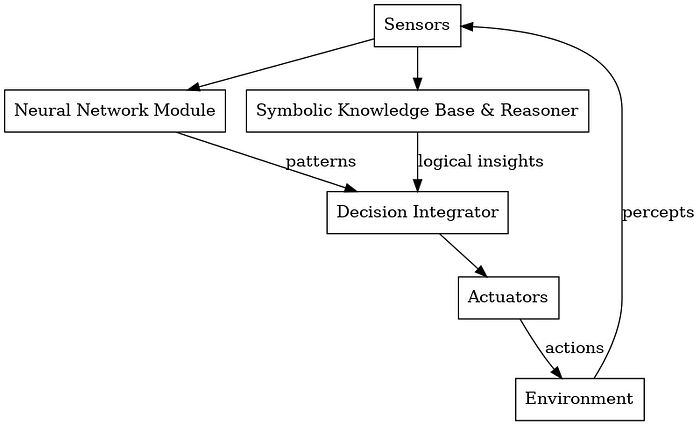

Có hai chiến lược tích hợp chính:
- Sequential: module neural xử lý các đầu vào, module biểu tượng lý giải các dữ liệu đầu ra đã được giải thích
- Parallel: Song song, cả hai module hoạt động đồng thời và một module quyết định hợp nhất cả hai đầu ra

```python
percept = get_sensor_data()
nn_insights = neural_module.predict(percept)         # Perception (e.g., detect anomaly)
sym_facts = symbolic_module.update(percept)          # Translate data to logical facts
sym_conclusions = symbolic_module.infer(sym_facts)   # Apply domain knowledge
decision = policy_module.decide(nn_insights, sym_conclusions)
execute(decision)
```


## 2.5 Cognitive Architecture
Kiến trúc nhận thức là khuôn khổ toàn diện được thiết kế để mô hình hóa trí thông minh giống con người nói chung bằng cách tích hợp nhận thức, trí nhớ, lý luận và học tập vào một hệ thống tác nhân thống nhất duy nhất
- được lấy cảm hứng từ con người
- Thực hiện chu trình Cảm nhận - Suy nghĩ - Hành động
1. Nhận thức môi trường
2. Cập nhật bộ nhớ làm việc
3. Lý luận và quyết định bằng cách sử dụng các quy tắc sản xuất
4. Hành động thông qua bộ truyền động

=> Mục tiêu là xây dựng các tác nhân có khả năng học hỏi, lập kế hoạch, giải quyết vấn đề và thích nghi giống như con người.

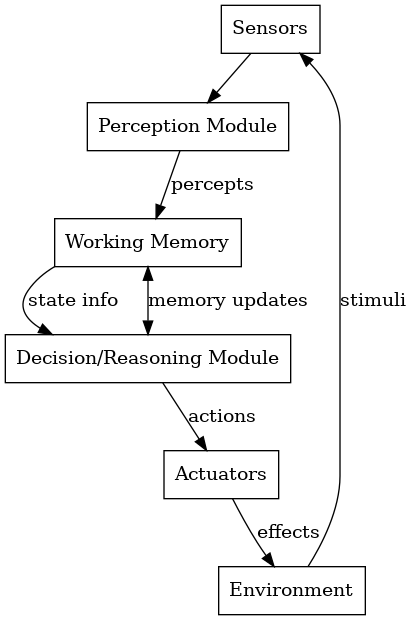

1. SOAR Architecture
- Được phát triển vào những năm 1980 cho hành vi thông minh nói chung. 
- Bộ nhớ làm việc: Lưu trữ tình huống hiện tại. Bộ nhớ sản xuất: Lưu trữ các quy tắc "nếu-thì". 
- Sử dụng mục tiêu phụ phổ quát — đặt mục tiêu phụ khi gặp khó khăn. 
- Học tập: Sử dụng "chunking" — chuyển đổi kinh nghiệm thành các quy tắc mới. 
- Các trường hợp sử dụng ví dụ: Phi công AI, robot hình người, tác nhân ra quyết định.

2. ACT-R Architecture
- Bắt nguồn từ tâm lý học nhận thức. 
- Bao gồm các mô-đun chuyên biệt (ví dụ: thị giác, vận động, trí nhớ). 
- Mỗi mô-đun sử dụng bộ đệm riêng cho bộ nhớ làm việc tạm thời. 
- Quy tắc sản xuất quản lý luồng dữ liệu giữa các bộ đệm. 
- Kết hợp lý luận biểu tượng với các cơ chế dưới biểu tượng (như kích hoạt bộ nhớ). 

Đặc điểm chung
- Thiết kế mô-đun (nhận thức, trí nhớ, mô-đun hành động). 
- Nhiều hệ thống bộ nhớ:
  - Declarative (facts)
  - Procedural (skills/rules)
  - Sometimes episodic (past events): Built-in learning (Soar's chunking, ACT-R's tuning).

Ví dụ:
```python
percept = perceive_environment()
update_working_memory(percept)
action = cognitive_reasoner.decide(working_memory)
execute(action)
```

Các kiến trúc nhận thức như SOAR và ACT-R cung cấp một mô hình trí tuệ toàn diện, tích hợp nhận thức, trí nhớ, ra quyết định và học tập. Chúng không chỉ giúp xây dựng các tác nhân thông minh — chúng còn giúp chúng ta hiểu cách thức hoạt động của tâm trí con người. Những hệ thống này lý tưởng cho các tác nhân cần học hỏi theo thời gian, xử lý các nhiệm vụ đa dạng và suy luận như con người.

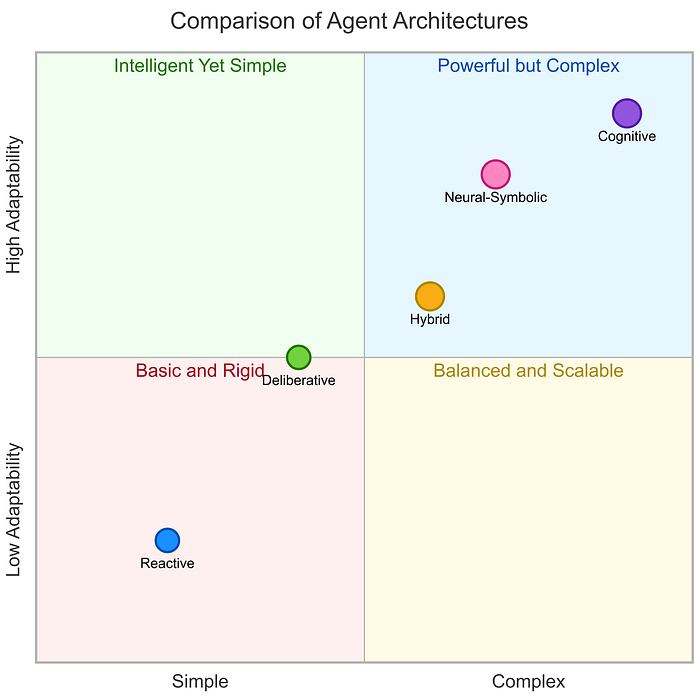


# 3. Agentic Design Patterns In LangGraph

Kiến trúc tác nhân và mẫu thiết kế tác nhân có liên quan chặt chẽ với nhau, nhưng chúng hoạt động ở các cấp độ trừu tượng khác nhau trong quá trình phát triển tác nhân AI.

- Kiến trúc thường tập trung nhiều hơn vào "cách thức" xây dựng hệ thống — các cơ chế cấp thấp và luồng dữ liệu hoặc điều khiển.
- Mặt khác, các Mẫu Thiết kế Agentic là các chiến lược hoặc khuôn mẫu cấp cao, có thể tái sử dụng để giải quyết các vấn đề cụ thể trong các hệ thống dựa trên tác nhân.
- Các mẫu thiết kế tập trung vào "cái gì" và "tại sao" — bạn muốn tác nhân thể hiện hành vi hoặc khả năng nào và tại sao hành vi hoặc khả năng đó lại hiệu quả trong một tình huống nhất định.

LangGraph đã tổ chức các kiến trúc tác nhân này thành ba nhóm chính:

## 3.1 Multi-Agent Systems
- Network: Cho phép hai hoặc nhiều tác nhân cộng tác trong một nhiệm vụ
- Supervisor: Sử dụng LLM để sắp xếp và phân công cho từng tác nhân
- Hierarchical Teams: Điều phối các nhóm tác nhân lồng nhau để giải quyết vấn đề

## 3.2 Planning Agents
- Plan-and-Execute: Triển khai một tác nhân lập kế hoạch và thực hiện cơ bản
- Reasoning without Observation: Giảm thiểu việc lập kế hoạch lại bằng cách lưu các quan sát dưới dạng biến
- LLMCompiler: Truyền phát và thực thi nhanh chóng một DAG các tác vụ từ một trình lập kế hoạch

## 3.3 Reflection & Critique
- Basic Reflection: Yêu cầu tác nhân suy nghĩ và sửa đổi kết quả đầu ra của mình
- Reflexion (Suy ngẫm): Phê bình những chi tiết còn thiếu và thừa để hướng dẫn các bước tiếp theo
- Tree of Thoughts: Tìm kiếm các giải pháp ứng viên cho một vấn đề bằng cách sử dụng cây ghi điểm
- Language Agent Tree Search: Sử dụng phản xạ và phần thưởng để thúc đẩy tìm kiếm cây Monte-Carlo trên các tác nhân
- Self-Discover Agent: Phân tích một tác nhân tìm hiểu về khả năng của chính nó.

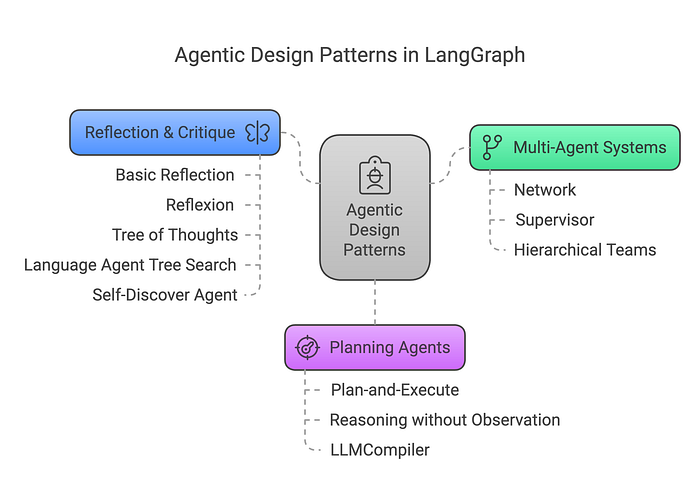

# 4. Multi-agent systems

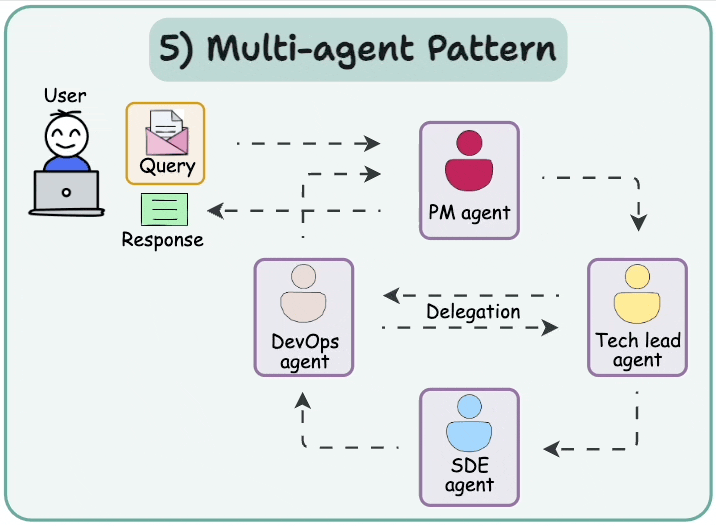

# 4.1 Multi-agent Network
Một trong những phương pháp để giải quyết vấn đề phức tạp là chia để trị. Sử dụng một router để route đến một agent con thực hiện một tác vụ cụ thể.
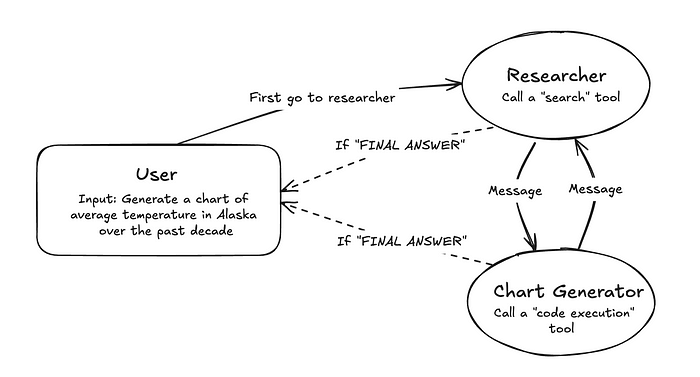

## 4.2 Multi-agent Supervisor
Tương tự với cái trên, nhưng điểm khác biệt là có một supervisor điều phối các agent thay vì router
4.2 Multi-agent Supervisor

## 4.3 Hierarchical Agent Teams
Nhóm tác nhân phân cấp xuất phát từ ý tưởng "Nếu một tác nhân duy nhất không đủ để giải quyết nhiệm vụ cụ thể thì sao?". Lúc này thay vì giám sát thì supervisor sẽ điều phối nhiều nhóm gồm nhiều người giám sát.
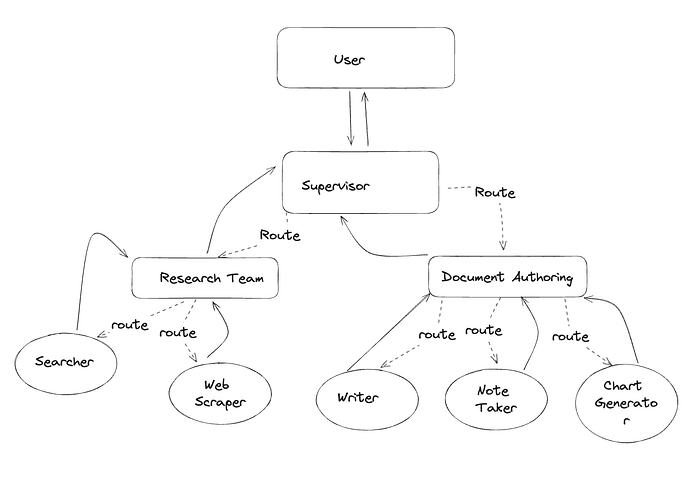

# 5. Planning Agents

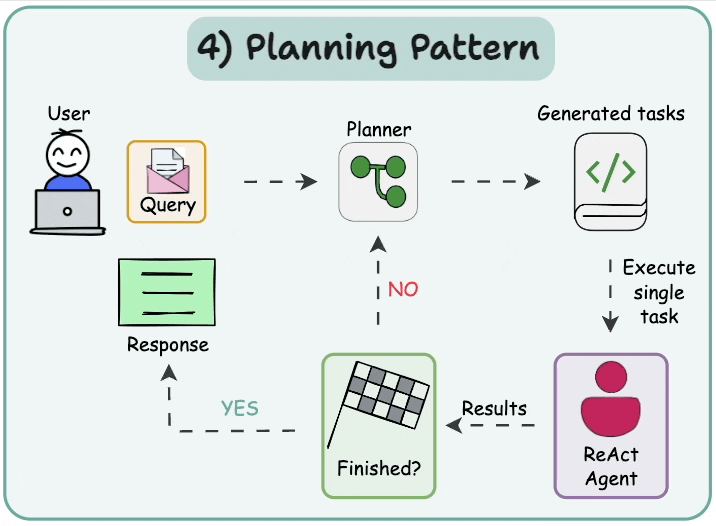
## 5.1 Plan-and-execute
Trong kiến trúc này, đầu tiên tác nhân sẽ thực thi generate subtasks theo thứ tự từng bước. Các tác nhân đơn nhiệm (chuyên biệt) giải quyết các nhiệm vụ con và nếu các nhiệm vụ được hoàn thành, các kết quả này sẽ được gửi lại cho tác nhân lập kế hoạch. Tác nhân lập kế hoạch sẽ tạo một kế hoạch khác tùy vào kết quả xử lý của kế hoạch trước đó. Nếu nhiệm vụ được hoàn thành, tác nhân sẽ trả kết quả cho người dùng.
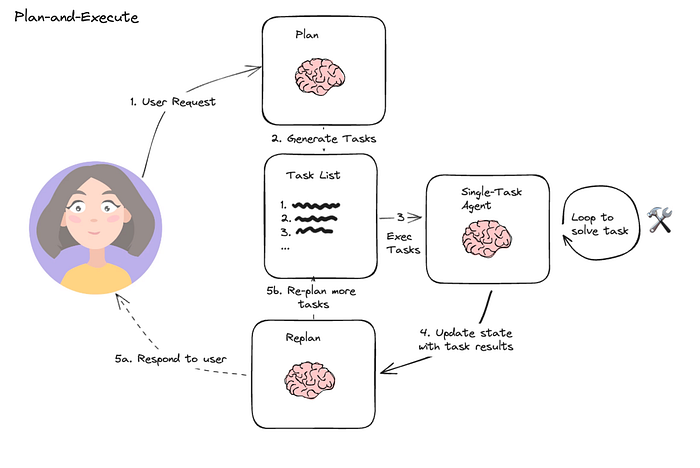

## 5.2 Reasoning without observation
Trong ReWOO, Xu và cộng sự giới thiệu một tác nhân tích hợp trình lập kế hoạch nhiều bước với phép thay thế biến để tối ưu hóa việc sử dụng công cụ. Cách tiếp cận này gần giống với kiến trúc lập kế hoạch và thực hiện. Tuy nhiên, không giống như các mô hình truyền thống, kiến trúc ReWOO không bao gồm bước quan sát sau mỗi hành động. Thay vào đó, toàn bộ kế hoạch được tạo ra trước và vẫn cố định, không bị ảnh hưởng bởi bất kỳ quan sát nào sau đó.
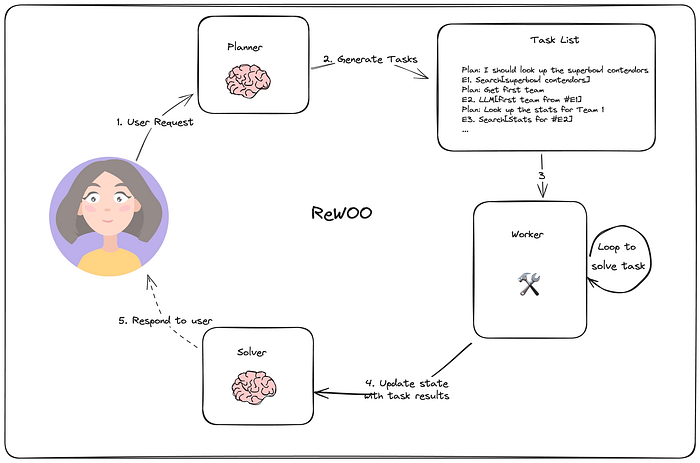

## 5.3 LLMCompiler
LLMCompiler là một kiến trúc tác nhân được thiết kế để tăng tốc độ thực thi các tác vụ tác nhân được thực thi nhanh chóng trong một DAG (Đồ thị không có chu trình có hướng - Directed Acyclic Graph). Nó cũng tiết kiệm chi phí sử dụng mã thông báo dư thừa bằng cách giảm số lượng lệnh gọi đến LLM. Dưới đây là tổng quan về đồ thị tính toán của nó:
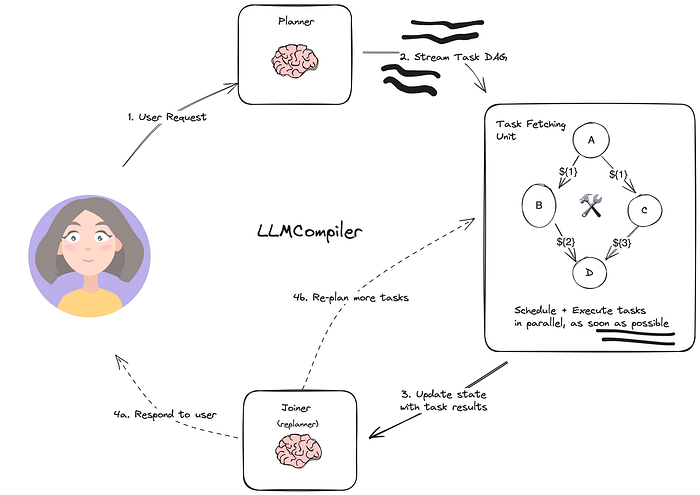

Nó có 3 thành phần chính: 
- Planner: tạo luồng DAG các tác vụ. 
- Task Fetching Unit: lên lịch và thực thi các tác vụ ngay khi chúng được thực thi. 
- Joiner: Phản hồi người dùng hoặc kích hoạt kế hoạch thứ hai

# 6. Reflection & Critique

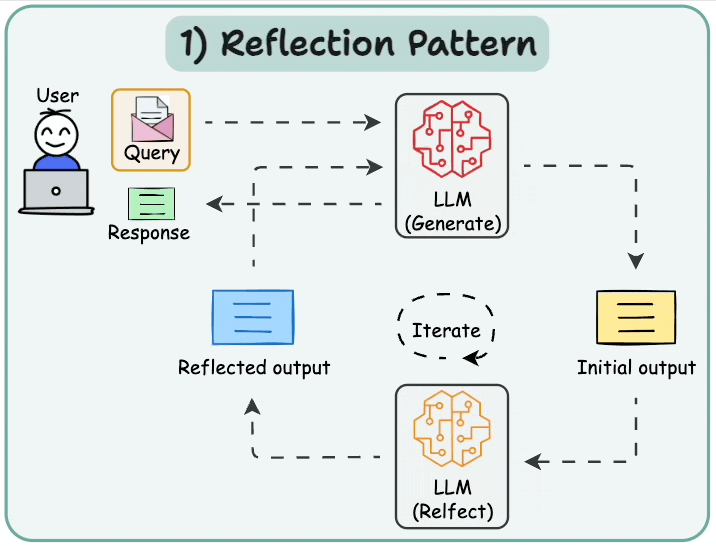

## 6.1 Basic Reflection
Các tác nhân phản ánh thúc đẩy một LLM suy ngẫm về những hành động trong quá khứ, cho phép nó học hỏi và cải thiện theo thời gian. Có hai tác nhân: tác nhân tạo ra và tác nhân phê bình. Ví dụ đơn giản nhất có thể là tác nhân người viết và tác nhân phê bình. Tác giả viết một văn bản tùy thuộc vào yêu cầu của người dùng và tác nhân phê bình xem xét văn bản, sau đó gửi phản hồi của họ trở lại cho tác giả. Vòng lặp này tiếp tục cho đến khi đạt được số lần lặp nhất định.

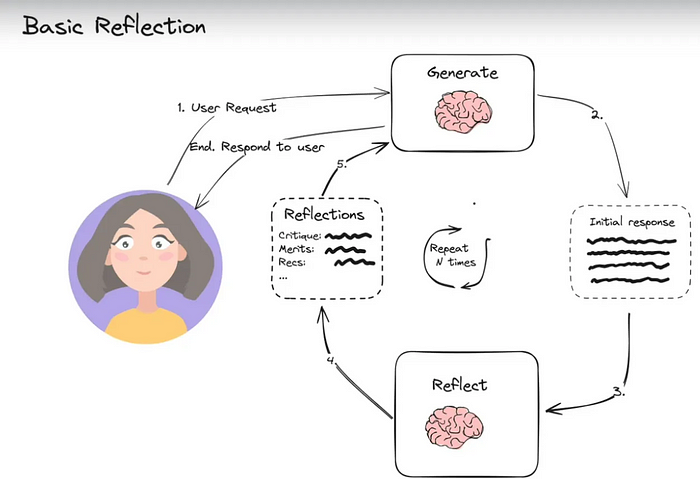

## 6.2 Reflexion
Reflexion của Shinn và cộng sự là một kiến trúc được thiết kế để học thông qua phản hồi bằng lời nói và tự phản ánh. Tác nhân phê bình rõ ràng các phản hồi của mình cho các tác vụ để tạo ra phản hồi cuối cùng chất lượng cao hơn, với cái giá phải trả là thời gian thực thi lâu hơn. Tác nhân Reflexion cũng bao gồm việc thực thi công cụ, trái ngược với kiến trúc phản ánh.

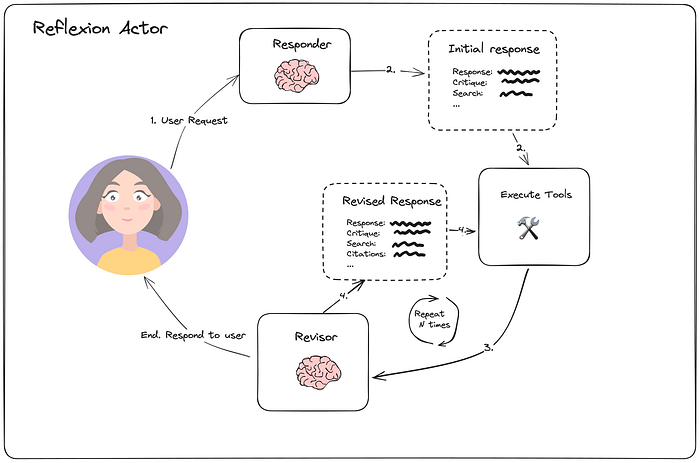

Bài báo phác thảo 3 thành phần chính: 
- Tác nhân (agent) có khả năng tự phản ánh 
- Đánh giá viên bên ngoài (tác vụ cụ thể, ví dụ: các bước biên dịch mã) 
- Bộ nhớ phân đoạn lưu trữ các phản ánh từ (1).

## 6.3 Tree of Thoughts
Tree-of-thoughts (ToT), do Yao và cộng sự thực hiện, là một thuật toán tìm kiếm tác nhân LLM tổng quát kết hợp phản ánh/đánh giá và tìm kiếm đơn giản (trong trường hợp này là BFS, mặc dù bạn có thể áp dụng DFS hoặc các thuật toán khác nếu muốn).

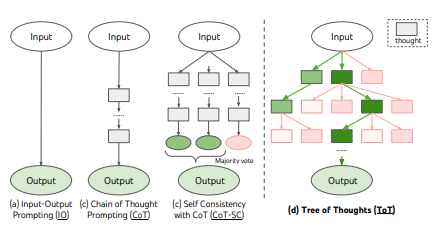

Nó có ba bước chính: 
- (Expand) Mở rộng: tạo ra 1 hoặc nhiều giải pháp ứng viên cho vấn đề. 
- (Score) Điểm: đo lường chất lượng của các phản hồi. 
- (Prune) Cắt tỉa: giữ lại K ứng viên tốt nhất.

Sau đó quay lại "Mở rộng" nếu không tìm thấy giải pháp (hoặc nếu giải pháp không đủ chất lượng).

## 6.4 Language Agent Tree Search
Language Agent Tree Search (LATS), do Zhou và cộng sự thực hiện, là một thuật toán tìm kiếm tác nhân LLM tổng quát kết hợp phản ánh/đánh giá và tìm kiếm (cụ thể là tìm kiếm cây Monte-Carlo) để đạt được hiệu suất tác vụ tổng thể tốt hơn so với các kỹ thuật tương tự như ReACT, Reflexion hoặc Tree of Thoughts.

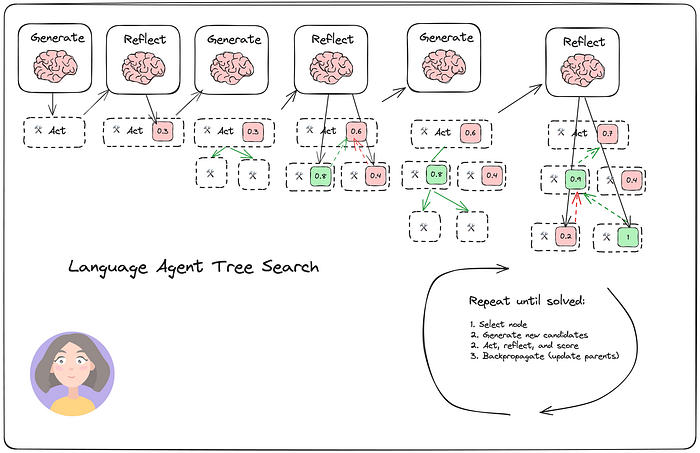

Thuật toán này có bốn bước chính: 
- Chọn: chọn các hành động tiếp theo tốt nhất dựa trên tổng phần thưởng từ bước (2). Hoặc phản hồi (nếu tìm thấy giải pháp hoặc đạt đến độ sâu tìm kiếm tối đa) hoặc tiếp tục tìm kiếm. 
- Mở rộng và mô phỏng: chọn 5 hành động tiềm năng "tốt nhất" để thực hiện và thực hiện chúng song song. 
- Suy ngẫm + Đánh giá: quan sát kết quả của các hành động này và chấm điểm các quyết định dựa trên suy ngẫm (và có thể là phản hồi từ bên ngoài). 
- Truyền ngược: cập nhật điểm của các quỹ đạo gốc dựa trên kết quả.

## 6.5 Self-Discover Agent
Tự khám phá giúp các Mô hình Ngôn ngữ Lớn (LLM) tìm ra cách tốt nhất để suy nghĩ thấu đáo và giải quyết các vấn đề khó khăn. - Đầu tiên, nó tìm ra một kế hoạch riêng cho mỗi vấn đề bằng cách chọn và thay đổi các bước lập luận cơ bản. 
- Sau đó, nó sử dụng kế hoạch này để giải quyết vấn đề từng bước. 

Bằng cách này, LLM sử dụng các công cụ lập luận khác nhau và điều chỉnh theo vấn đề để đưa ra giải pháp hiệu quả hơn so với việc chỉ sử dụng một phương pháp.

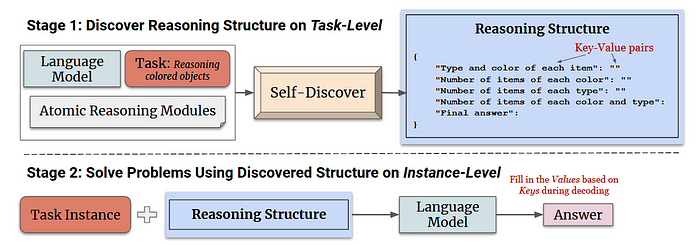

Phương pháp Tự khám phá nổi bật so với các phương pháp lập kế hoạch khác vì nó tự động tạo ra một chiến lược lập luận độc đáo cho mỗi nhiệm vụ. Điểm khác biệt của nó là: 
- Các mô-đun lập luận: Phương pháp này sử dụng các bước lập luận cơ bản và sắp xếp chúng theo một thứ tự cụ thể 
- Không cần sự trợ giúp của con người: Phương pháp này tự tìm ra các chiến lược này mà không cần con người dán nhãn nhiệm vụ - Thích ứng với nhiệm vụ: Phương pháp này tìm ra cách tốt nhất để giải quyết từng vấn đề, giống như cách con người lập kế hoạch 
- Có thể chuyển giao: Các chiến lược lập luận mà nó tạo ra có thể được sử dụng bởi các loại mô hình ngôn ngữ khác nhau 
  
Tóm lại, Phương pháp Tự khám phá là phương pháp độc đáo vì nó kết hợp các phương pháp lập luận khác nhau để tạo ra một kế hoạch mà không cần hướng dẫn nhiệm vụ cụ thể.

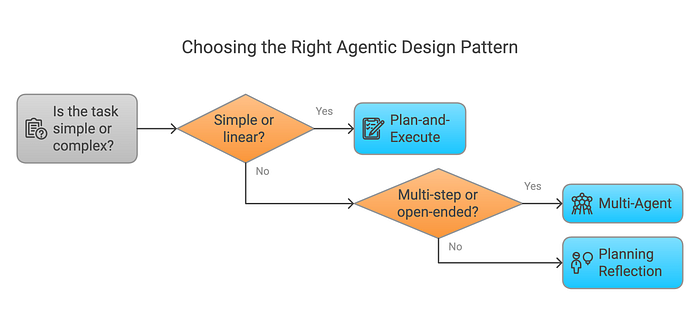

# 7. Conclusion

- khám phá bối cảnh phát triển của kiến trúc tác tử, từ các mô hình phản ứng và cân nhắc truyền thống đến các hệ thống lai, thần kinh-biểu tượng và nhận thức tiên tiến hơn
- kết nối các khái niệm nền tảng này với các triển khai hiện đại sử dụng LangGraph, giới thiệu các mô hình thiết kế tác tử mạnh mẽ như lập kế hoạch, cộng tác, phản biện và phê bình
- Khi chúng ta tiếp tục xây dựng các hệ thống ngày càng thông minh và tự chủ, việc hiểu và áp dụng các nguyên tắc kiến trúc này sẽ là chìa khóa để mở ra các giải pháp AI có khả năng mở rộng, mô-đun và hướng đến mục tiêu.
- Tương lai của AI không nằm ở trí thông minh biệt lập mà nằm ở các tác tử phối hợp, phản biện và có mục đích làm việc cùng nhau để giải quyết các nhiệm vụ phức tạp